In [1]:
!head -n 10 GPa-REF-extxyz-MPtrj_2022.extxyz

1
Lattice="-3.0350415 -3.0612434 3.023897 -3.03443919 3.05010836 -3.03441297 3.02392335 -3.06125588 -3.03503011" Properties=species:S:1:pos:R:3:REF_forces:R:3 REF_energy=-0.85856052 REF_stress="0.03614817 0.01113947 0.01125051 0.01113947 0.09315311 0.01114297 0.01125051 0.01114297 0.03613660" pbc="T T T"
Cs            3.02382441     -3.06130470     -3.03496358     -0.00002504      0.00000055     -0.00000033
1
Lattice="-3.03690553 -3.06608684 3.02459337 -3.03630424 3.05378431 -3.03627724 3.02462051 -3.06609969 -3.03689372" Properties=species:S:1:pos:R:3:REF_forces:R:3 REF_energy=-0.8586399 REF_stress="0.02783625 0.01156976 0.01183099 0.01156976 0.08729610 0.01146089 0.01183099 0.01146089 0.02784803" pbc="T T T"
Cs            3.02452091     -3.06614860     -3.03682717     -0.00010089     -0.00017874      0.00006877
1
Lattice="-3.04249763 -3.08061715 3.02668249 -3.0418994 3.06481214 -3.04187004 3.026712 -3.08063112 -3.04248455" Properties=species:S:1:pos:R:3:REF_forces:R:3 REF_energy=-0.8

Materials Project C-H-N-O数据筛选分析
目标元素: {'O', 'H', 'N', 'C'}
输入文件: GPa-REF-extxyz-MPtrj_2022.extxyz
读取Materials Project数据: GPa-REF-extxyz-MPtrj_2022.extxyz
总结构数量: 1580395
处理进度: 10000/1580395
处理进度: 20000/1580395
处理进度: 30000/1580395
处理进度: 40000/1580395
处理进度: 50000/1580395
处理进度: 60000/1580395
处理进度: 70000/1580395
处理进度: 80000/1580395
处理进度: 90000/1580395
处理进度: 100000/1580395
处理进度: 110000/1580395
处理进度: 120000/1580395
处理进度: 130000/1580395
处理进度: 140000/1580395
处理进度: 150000/1580395
处理进度: 160000/1580395
处理进度: 170000/1580395
处理进度: 180000/1580395
处理进度: 190000/1580395
处理进度: 200000/1580395
处理进度: 210000/1580395
处理进度: 220000/1580395
处理进度: 230000/1580395
处理进度: 240000/1580395
处理进度: 250000/1580395
处理进度: 260000/1580395
处理进度: 270000/1580395
处理进度: 280000/1580395
处理进度: 290000/1580395
处理进度: 300000/1580395
处理进度: 310000/1580395
处理进度: 320000/1580395
处理进度: 330000/1580395
处理进度: 340000/1580395
处理进度: 350000/1580395
处理进度: 360000/1580395
处理进度: 370000/1580395
处理进度: 380000/1580395
处理进度: 390000/1580395
处理进度: 400000/1580395


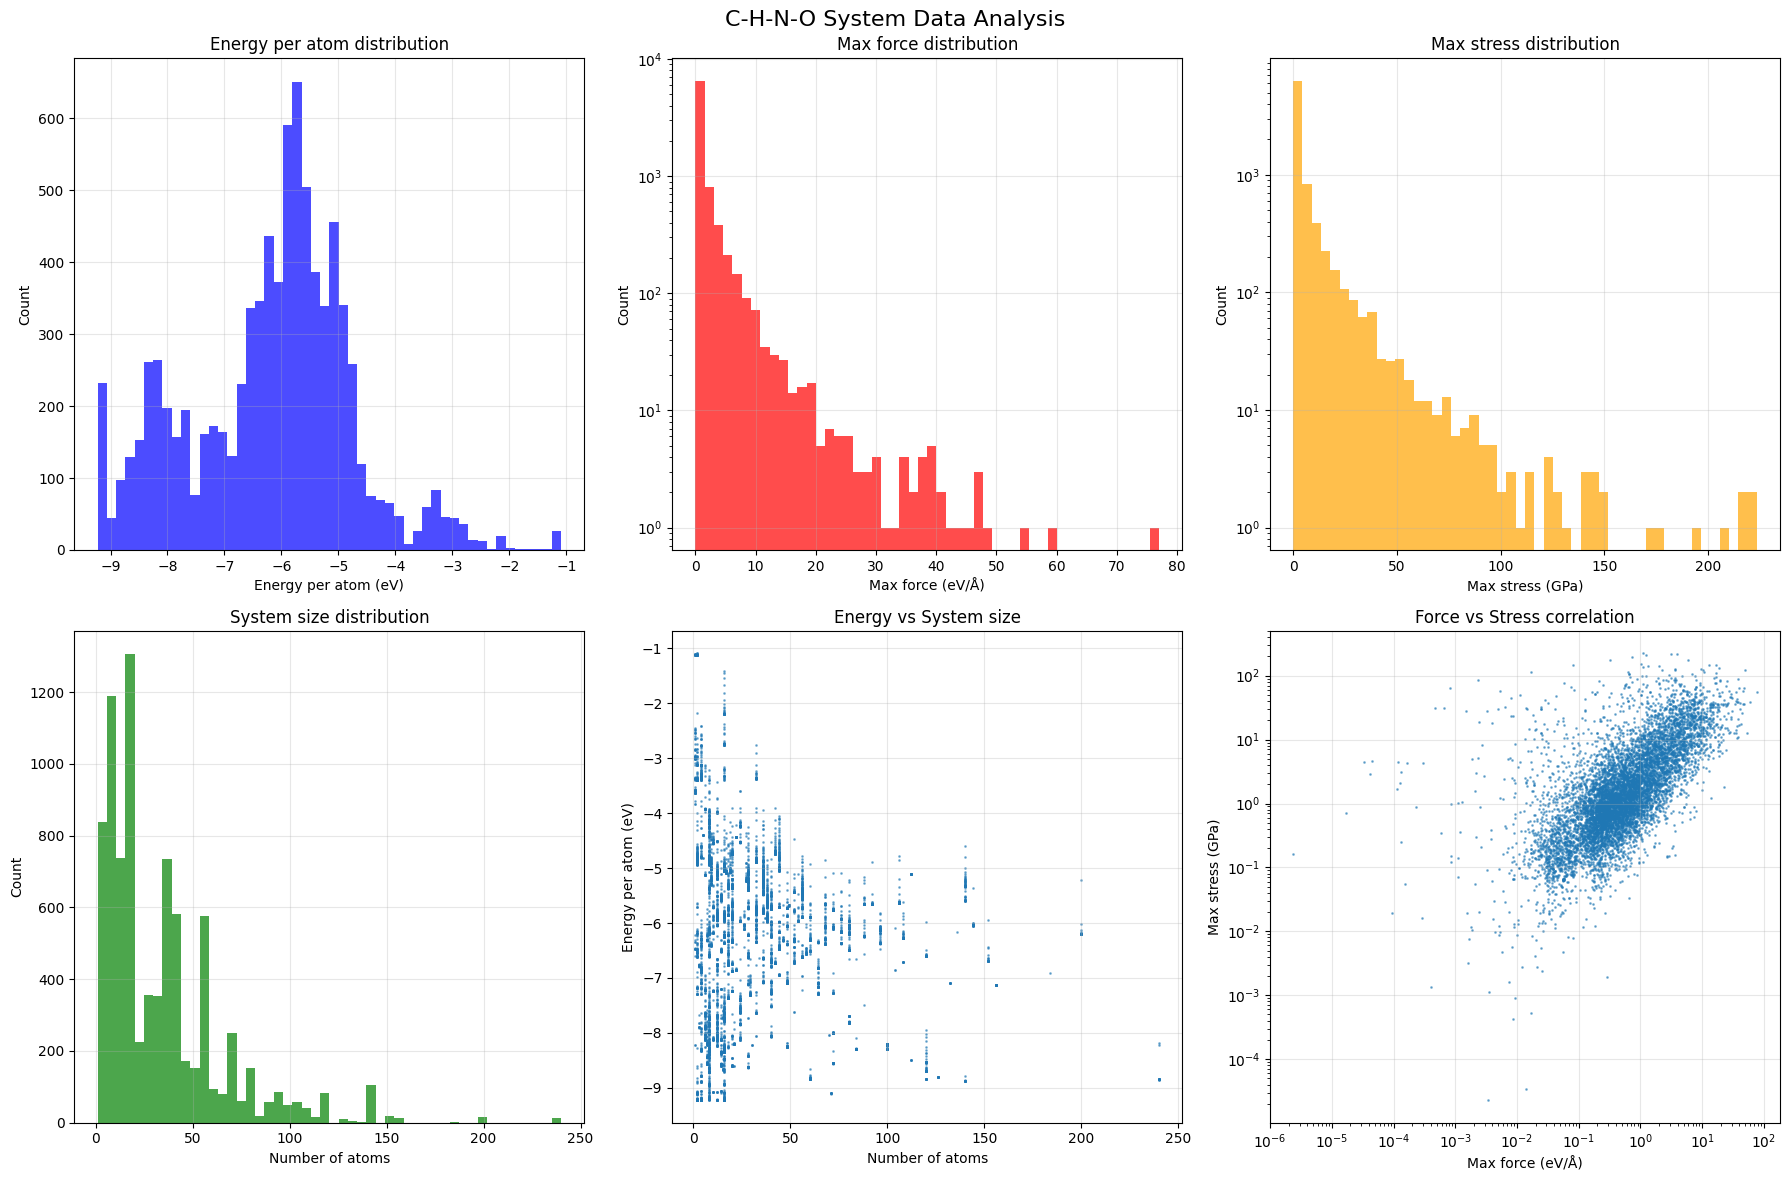

总结和建议:
保守筛选: 6696 个结构 → 使用 chno_conservative.extxyz
推荐筛选: 58 个结构 → 使用 chno_recommended.extxyz
严格筛选: 22 个结构 → 使用 chno_strict.extxyz

针对C-H-N-O体系的建议:
1. 如果数据量充足(>1000个结构)，使用'推荐筛选'
2. 如果数据量较少，使用'保守筛选'
3. 如果追求最高质量，使用'严格筛选'

MACE训练命令示例:
mace_run_train --train_file=chno_recommended.extxyz --valid_fraction=0.1 --test_fraction=0.1 \
               --model=MACE --hidden_irreps='128x0e+128x1o' --r_max=5.0 \
               --batch_size=16 --max_num_epochs=200 --lr=0.001 \
               --energy_weight=1.0 --forces_weight=50.0 --stress_weight=10.0


In [3]:
import ase.io
import numpy as np
from collections import Counter, defaultdict
import pandas as pd
import matplotlib.pyplot as plt

class Config:
    TARGET_ELEMENTS = {'H', 'C', 'N', 'O'} 
    INPUT_FILE = "GPa-REF-extxyz-MPtrj_2022.extxyz"
    OUTPUT_PREFIX = "".join(sorted(TARGET_ELEMENTS)).lower()
    
    FILTERING_SCENARIOS = [
        {
            'name': '保守筛选',
            'max_atoms': 100,
            'force_percentile': 95,  
            'stress_percentile': 95,
            'custom_max_force': None,
            'custom_max_stress': None,
            'filename_suffix': 'conservative'
        },
        {
            'name': '推荐筛选', 
            'max_atoms': 50,
            'force_percentile': 90,
            'stress_percentile': 90,
            'custom_max_force': 0.1,
            'custom_max_stress': 0.05,
            'filename_suffix': 'recommended'
        },
        {
            'name': '严格筛选',
            'max_atoms': 30,
            'force_percentile': 85,
            'stress_percentile': 85,
            'custom_max_force': 0.05,
            'custom_max_stress': 0.02,
            'filename_suffix': 'strict'
        }
    ]

    ENERGY_LOW_PERCENTILE = 5
    ENERGY_HIGH_PERCENTILE = 95
    SAVE_PLOTS = True
    PLOT_DPI = 300

def analyze_mp_data(filename):
    print(f"读取Materials Project数据: {filename}")
    atoms_list = ase.io.read(filename, ':')
    total = len(atoms_list)
    
    print(f"总结构数量: {total}")
    print("="*60)
    
    stats = []
    element_sets = set()
    compositions = []
    
    for i, atoms in enumerate(atoms_list):
        natoms = len(atoms)
        symbols = atoms.get_chemical_symbols()
        unique_elements = set(symbols)
        element_sets.add(frozenset(unique_elements))

        composition = Counter(symbols)
        comp_str = ''.join([f"{elem}{count}" if count > 1 else elem 
                           for elem, count in sorted(composition.items())])
        compositions.append(comp_str)

        energy = atoms.info.get('REF_energy', atoms.info.get('energy', 0))
        forces = atoms.arrays.get('REF_forces', atoms.arrays.get('forces', np.zeros((natoms, 3))))
        stress = atoms.info.get('REF_stress', atoms.info.get('stress', np.zeros(6)))
        
        max_force = np.linalg.norm(forces, axis=1).max() if len(forces) > 0 else 0
        max_stress = np.abs(stress).max() if hasattr(stress, '__len__') and len(stress) > 0 else 0
        energy_per_atom = energy / natoms
  
        element_counts = {elem: composition.get(elem, 0) for elem in Config.TARGET_ELEMENTS}
        
        stat_dict = {
            'index': i,
            'natoms': natoms,
            'elements': unique_elements,
            'composition': comp_str,
            'energy': energy,
            'energy_per_atom': energy_per_atom,
            'max_force': max_force,
            'max_stress': max_stress,
        }
        
        stat_dict.update({f"{elem}_count": count for elem, count in element_counts.items()})
        
        stats.append(stat_dict)
        
        if (i + 1) % 10000 == 0:
            print(f"处理进度: {i+1}/{total}")
    
    return stats, element_sets, compositions

def filter_target_compositions(stats):
    target_elements = Config.TARGET_ELEMENTS
    target_str = '-'.join(sorted(target_elements))
    
    filtered_stats = []
    
    for stat in stats:
        elements = stat['elements']
        
        if elements.issubset(target_elements) and len(elements) > 0:
            if any(elem in elements for elem in target_elements):
                filtered_stats.append(stat)
    
    return filtered_stats

def detailed_composition_analysis(filtered_stats):
    target_str = '-'.join(sorted(Config.TARGET_ELEMENTS))
    print(f"{target_str}体系组成分析:")
    print("="*60)
    
    comp_stats = defaultdict(list)
    element_combination_stats = defaultdict(int)
    
    for stat in filtered_stats:
        comp_stats[stat['composition']].append(stat)
        
        elements = stat['elements']
        if elements:
            elem_combo = '-'.join(sorted(elements))
            element_combination_stats[elem_combo] += 1
    
    print("1. 元素组合统计:")
    for combo, count in sorted(element_combination_stats.items(), key=lambda x: x[1], reverse=True):
        print(f"   {combo:<20}: {count:>6} 个结构")
    print()
    
    print("2. 主要化学组成 (前20个):")
    comp_counts = {comp: len(structures) for comp, structures in comp_stats.items()}
    sorted_comps = sorted(comp_counts.items(), key=lambda x: x[1], reverse=True)
    
    for comp, count in sorted_comps[:20]:
        print(f"   {comp:<25}: {count:>6} 个结构")
    print()
    
    return comp_stats, element_combination_stats

def recommend_filtering_criteria(filtered_stats):
    df = pd.DataFrame(filtered_stats)
    
    print("3. 数据质量分析:")
    print(f"   能量范围: {df['energy'].min():.6f} 到 {df['energy'].max():.6f} eV")
    print(f"   单原子能量范围: {df['energy_per_atom'].min():.6f} 到 {df['energy_per_atom'].max():.6f} eV")
    print(f"   原子数范围: {df['natoms'].min()} 到 {df['natoms'].max()}")
    print(f"   力范围: {df['max_force'].min():.6f} 到 {df['max_force'].max():.6f} eV/Å")
    print(f"   应力范围: {df['max_stress'].min():.6f} 到 {df['max_stress'].max():.6f} GPa")
    print()
    
    force_percentiles = [50, 90, 95, 99]
    stress_percentiles = [50, 90, 95, 99]
    energy_percentiles = [1, 5, 95, 99]
    
    print("4. 力分布百分位数:")
    force_percentile_values = {}
    for p in force_percentiles:
        val = np.percentile(df['max_force'], p)
        force_percentile_values[p] = val
        print(f"   {p}%: {val:.6f} eV/Å")
    print()
    
    print("5. 应力分布百分位数:")
    stress_percentile_values = {}
    for p in stress_percentiles:
        val = np.percentile(df['max_stress'], p)
        stress_percentile_values[p] = val
        print(f"   {p}%: {val:.6f} GPa")
    print()
    
    print("6. 单原子能量分布百分位数:")
    energy_low = np.percentile(df['energy_per_atom'], Config.ENERGY_LOW_PERCENTILE)
    energy_high = np.percentile(df['energy_per_atom'], Config.ENERGY_HIGH_PERCENTILE)
    
    for p in energy_percentiles:
        val = np.percentile(df['energy_per_atom'], p)
        print(f"   {p}%: {val:.6f} eV")
    print()
    
    return {
        'force_percentiles': force_percentile_values,
        'stress_percentiles': stress_percentile_values,
        'energy_range': (energy_low, energy_high)
    }

def apply_filtering(atoms_list, criteria):
    target_elements = Config.TARGET_ELEMENTS
    target_str = Config.OUTPUT_PREFIX
    
    print("7. 应用筛选条件:")
    print("="*60)
    
    results = {}
    
    for scenario in Config.FILTERING_SCENARIOS:
        if scenario['custom_max_force'] is not None:
            max_force_threshold = scenario['custom_max_force']
        else:
            max_force_threshold = criteria['force_percentiles'][scenario['force_percentile']]
            
        if scenario['custom_max_stress'] is not None:
            max_stress_threshold = scenario['custom_max_stress']
        else:
            max_stress_threshold = criteria['stress_percentiles'][scenario['stress_percentile']]
        
        filename = f"{target_str}_{scenario['filename_suffix']}.extxyz"
        
        filtered_atoms = []
        stats = {'total': 0, 'element_filtered': 0, 'force_filtered': 0, 
                'stress_filtered': 0, 'size_filtered': 0, 'energy_filtered': 0, 'kept': 0}
        
        for atoms in atoms_list:
            stats['total'] += 1
            
            symbols = atoms.get_chemical_symbols()
            unique_elements = set(symbols)
            if not unique_elements.issubset(target_elements):
                stats['element_filtered'] += 1
                continue

            forces = atoms.arrays.get('REF_forces', atoms.arrays.get('forces', np.zeros((len(atoms), 3))))
            max_force = np.linalg.norm(forces, axis=1).max() if len(forces) > 0 else 0
            if max_force > max_force_threshold:
                stats['force_filtered'] += 1
                continue
                
            stress = atoms.info.get('REF_stress', atoms.info.get('stress', np.zeros(6)))
            max_stress = np.abs(stress).max() if hasattr(stress, '__len__') and len(stress) > 0 else 0
            if max_stress > max_stress_threshold:
                stats['stress_filtered'] += 1
                continue
            
            natoms = len(atoms)
            if natoms > scenario['max_atoms']:
                stats['size_filtered'] += 1
                continue

            energy = atoms.info.get('REF_energy', atoms.info.get('energy', 0))
            energy_per_atom = energy / natoms
            energy_range = criteria['energy_range']
            if not (energy_range[0] <= energy_per_atom <= energy_range[1]):
                stats['energy_filtered'] += 1
                continue
            
            filtered_atoms.append(atoms)
            stats['kept'] += 1

        if filtered_atoms:
            ase.io.write(filename, filtered_atoms)
            
        results[scenario['name']] = {
            'atoms': filtered_atoms,
            'stats': stats,
            'filename': filename
        }
        
        print(f"{scenario['name']}:")
        print(f"   条件: 力<{max_force_threshold:.4f} eV/Å, 应力<{max_stress_threshold:.4f} GPa, 原子数<{scenario['max_atoms']}, 能量{energy_range[0]:.3f}到{energy_range[1]:.3f} eV")
        total = stats['total']
        kept = stats['kept']
        print(f"   结果: {kept}/{total} 个结构 ({kept/total*100:.1f}%)")
        print(f"   过滤统计: 元素{stats['element_filtered']}, 力{stats['force_filtered']}, 应力{stats['stress_filtered']}, 尺寸{stats['size_filtered']}, 能量{stats['energy_filtered']}")
        print(f"   保存: {filename}")
        print()
    
    return results

def plot_data_analysis(filtered_stats, save_plots=True):
    df = pd.DataFrame(filtered_stats)
    target_str = '-'.join(sorted(Config.TARGET_ELEMENTS))
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    axes[0,0].hist(df['energy_per_atom'], bins=50, alpha=0.7, color='blue')
    axes[0,0].set_xlabel('Energy per atom (eV)')
    axes[0,0].set_ylabel('Count')
    axes[0,0].set_title('Energy per atom distribution')
    axes[0,0].grid(True, alpha=0.3)
    
    axes[0,1].hist(df['max_force'], bins=50, alpha=0.7, color='red')
    axes[0,1].set_xlabel('Max force (eV/Å)')
    axes[0,1].set_ylabel('Count')
    axes[0,1].set_title('Max force distribution')
    axes[0,1].set_yscale('log')
    axes[0,1].grid(True, alpha=0.3)
    
    axes[0,2].hist(df['max_stress'], bins=50, alpha=0.7, color='orange')
    axes[0,2].set_xlabel('Max stress (GPa)')
    axes[0,2].set_ylabel('Count')
    axes[0,2].set_title('Max stress distribution')
    axes[0,2].set_yscale('log')
    axes[0,2].grid(True, alpha=0.3)
    
    axes[1,0].hist(df['natoms'], bins=50, alpha=0.7, color='green')
    axes[1,0].set_xlabel('Number of atoms')
    axes[1,0].set_ylabel('Count')
    axes[1,0].set_title('System size distribution')
    axes[1,0].grid(True, alpha=0.3)
    
    axes[1,1].scatter(df['natoms'], df['energy_per_atom'], alpha=0.5, s=1)
    axes[1,1].set_xlabel('Number of atoms')
    axes[1,1].set_ylabel('Energy per atom (eV)')
    axes[1,1].set_title('Energy vs System size')
    axes[1,1].grid(True, alpha=0.3)
    
    axes[1,2].scatter(df['max_force'], df['max_stress'], alpha=0.5, s=1)
    axes[1,2].set_xlabel('Max force (eV/Å)')
    axes[1,2].set_ylabel('Max stress (GPa)')
    axes[1,2].set_title('Force vs Stress correlation')
    axes[1,2].set_xscale('log')
    axes[1,2].set_yscale('log')
    axes[1,2].grid(True, alpha=0.3)
    
    plt.suptitle(f'{target_str} System Data Analysis', fontsize=16)
    plt.tight_layout()
    
    if save_plots:
        plot_filename = f'{Config.OUTPUT_PREFIX}_data_analysis.png'
        plt.savefig(plot_filename, dpi=Config.PLOT_DPI, bbox_inches='tight')
        print(f"数据分析图已保存: {plot_filename}")
    
    plt.show()

def main():
    target_str = '-'.join(sorted(Config.TARGET_ELEMENTS))
    print(f"Materials Project {target_str}数据筛选分析")
    print("="*60)
    print(f"目标元素: {Config.TARGET_ELEMENTS}")
    print(f"输入文件: {Config.INPUT_FILE}")
    print("="*60)
    
    stats, element_sets, compositions = analyze_mp_data(Config.INPUT_FILE)
    
    target_stats = filter_target_compositions(stats)
    print(f"{target_str}体系结构数量: {len(target_stats)}")
    print()
    
    if len(target_stats) == 0:
        print(f"错误: 没有找到{target_str}体系的结构！")
        print("请检查:")
        print("1. 文件路径是否正确")
        print("2. 目标元素设置是否正确")
        print("3. 数据文件是否包含这些元素的组合")
        return
    
    comp_stats, elem_combo_stats = detailed_composition_analysis(target_stats)
    
    criteria = recommend_filtering_criteria(target_stats)
    
    atoms_list = ase.io.read(Config.INPUT_FILE, ':')
    results = apply_filtering(atoms_list, criteria)
    
    plot_data_analysis(target_stats, Config.SAVE_PLOTS)
    
    print("总结和建议:")
    print("="*60)
    for name, result in results.items():
        count = result['stats']['kept']
        if count > 0:
            print(f"{name}: {count} 个结构 → 使用 {result['filename']}")
    
    print(f"\n针对{target_str}体系的建议:")
    print("1. 如果数据量充足(>1000个结构)，使用'推荐筛选'")
    print("2. 如果数据量较少，使用'保守筛选'") 
    print("3. 如果追求最高质量，使用'严格筛选'")
    print(f"\nMACE训练命令示例:")
    recommended_file = f"{Config.OUTPUT_PREFIX}_recommended.extxyz"
    print(f"mace_run_train --train_file={recommended_file} --valid_fraction=0.1 --test_fraction=0.1 \\")
    print("               --model=MACE --hidden_irreps='128x0e+128x1o' --r_max=5.0 \\")
    print("               --batch_size=16 --max_num_epochs=200 --lr=0.001 \\")
    print("               --energy_weight=1.0 --forces_weight=50.0 --stress_weight=10.0")

if __name__ == "__main__":
    main()

CHNO Conservative数据可视化分析
分析筛选数据: chno_conservative.extxyz
筛选后结构数量: 6696

详细统计信息:
1. 基本统计:
   总结构数: 6696
   原子数范围: 1 - 100
   平均原子数: 31.4

2. 能量统计:
   能量范围: -829.406882 - -6.316736 eV
   单原子能量范围: -8.665790 - -3.986561 eV
   单原子能量平均: -6.199797 eV

3. 力学性质统计:
   最大力范围: 0.000000 - 7.052028 eV/Å
   平均力范围: 0.000000 - 6.668782 eV/Å
   最大应力范围: 0.000023 - 26.552023 GPa

4. 元素组合统计:
   HNO: 1888 个结构 (28.2%)
   CHNO: 1073 个结构 (16.0%)
   CN: 592 个结构 (8.8%)
   NO: 462 个结构 (6.9%)
   CHO: 454 个结构 (6.8%)
   CO: 395 个结构 (5.9%)
   HO: 363 个结构 (5.4%)
   O: 319 个结构 (4.8%)
   C: 305 个结构 (4.6%)
   CNO: 249 个结构 (3.7%)
   CHN: 189 个结构 (2.8%)
   CH: 152 个结构 (2.3%)
   N: 151 个结构 (2.3%)
   HN: 104 个结构 (1.6%)

5. 主要化学组成 (前10个):
   H28N4O24: 415 个结构
   H16N8O12: 277 个结构
   H12N8O18: 269 个结构
   O8: 164 个结构
   H12N4O16: 133 个结构
   C4H8O8: 121 个结构
   C4O8: 120 个结构
   H32N8O4: 112 个结构
   N4O4: 104 个结构
   H4N4O4: 99 个结构

6. 元素比例统计:
   H比例 (非零): 平均=0.463, 中位数=0.450, 标准差=0.133
   C比例 (非零): 平均=0.383, 中位数=0.333, 标准差=0.276
 

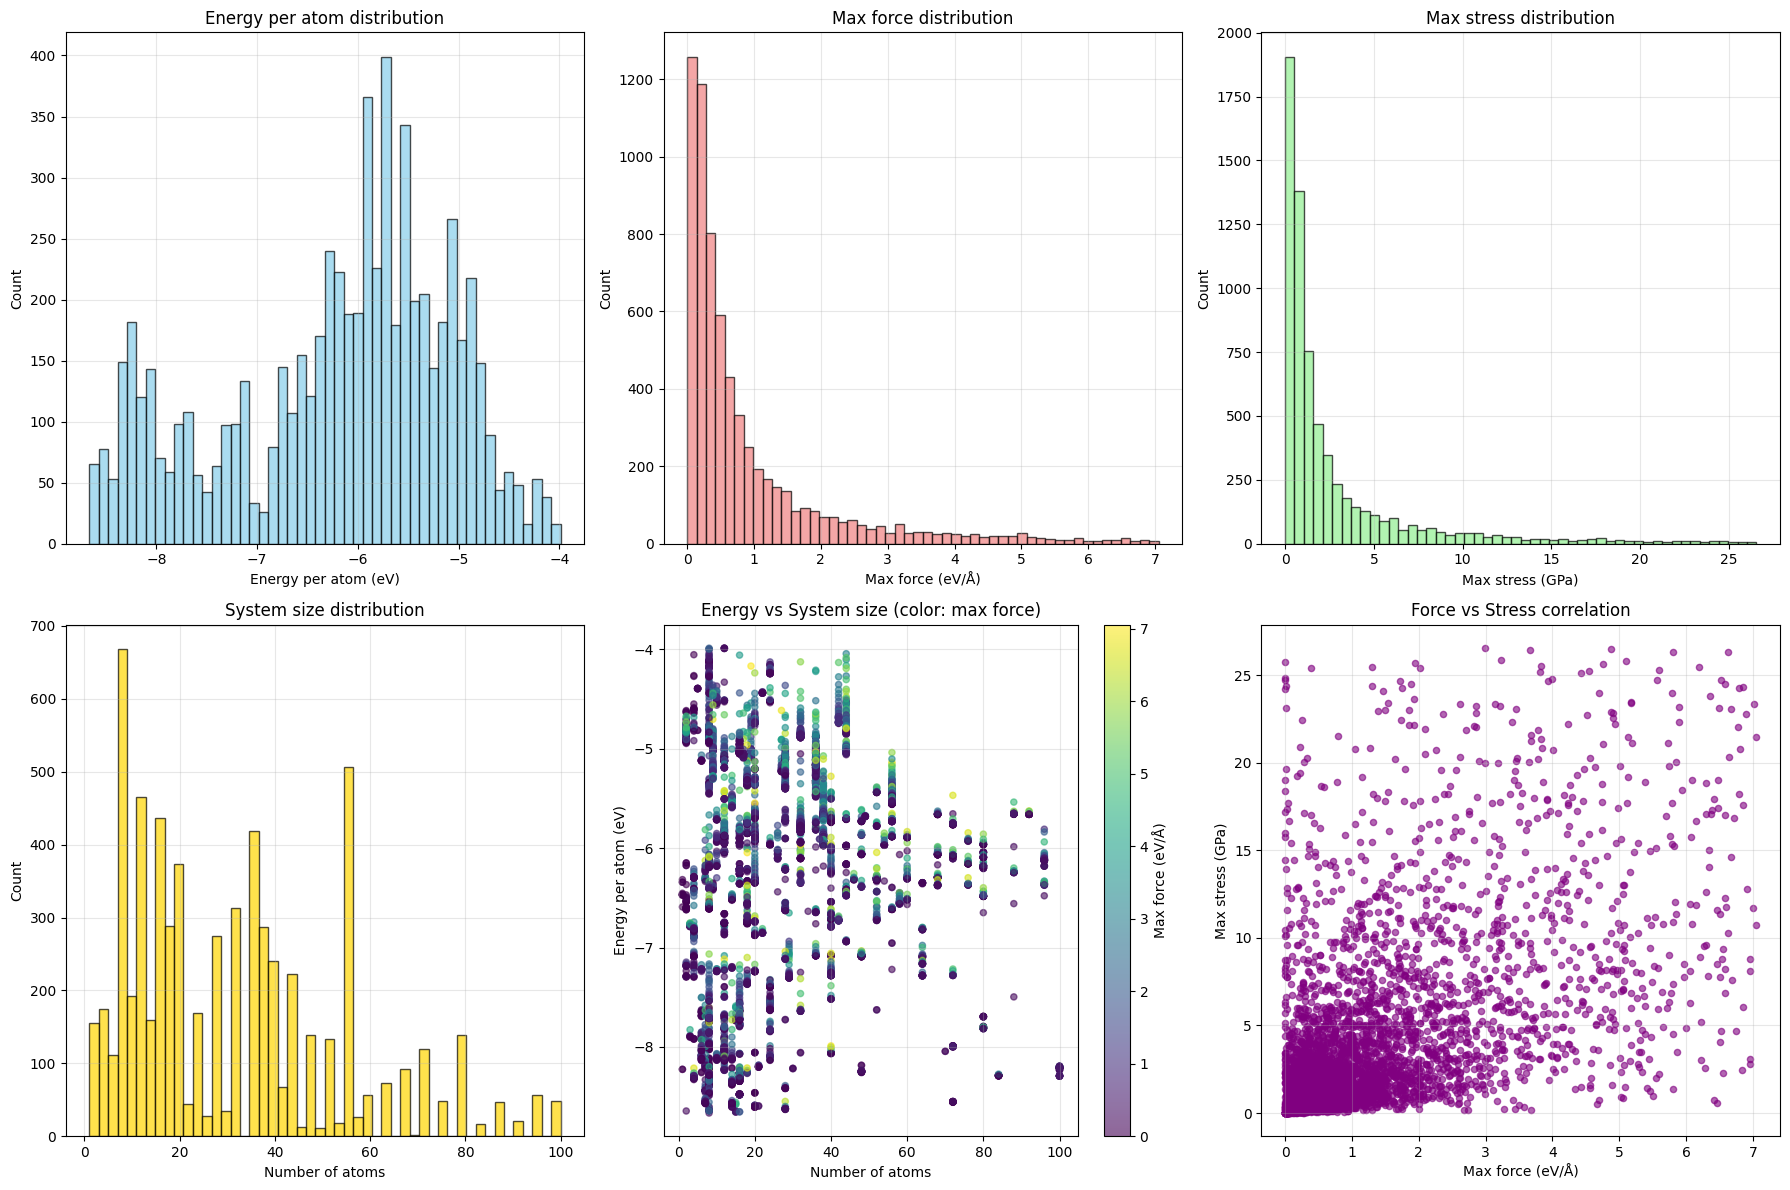

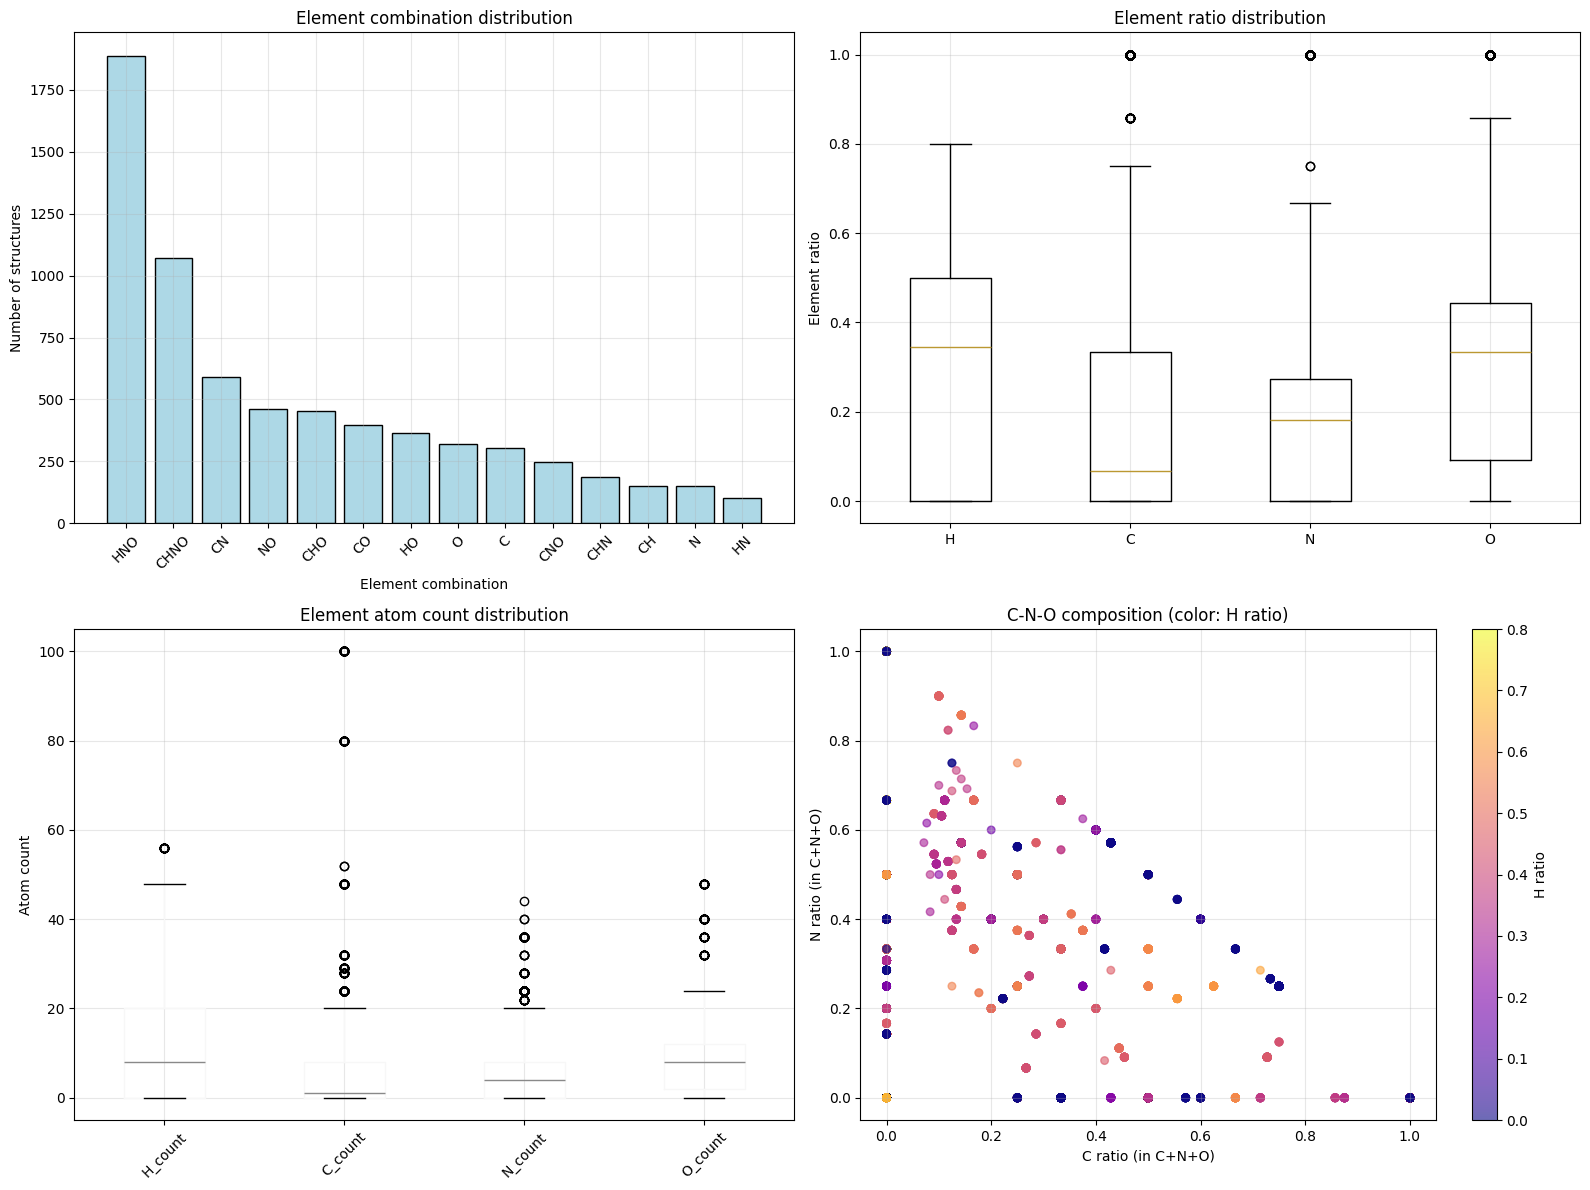

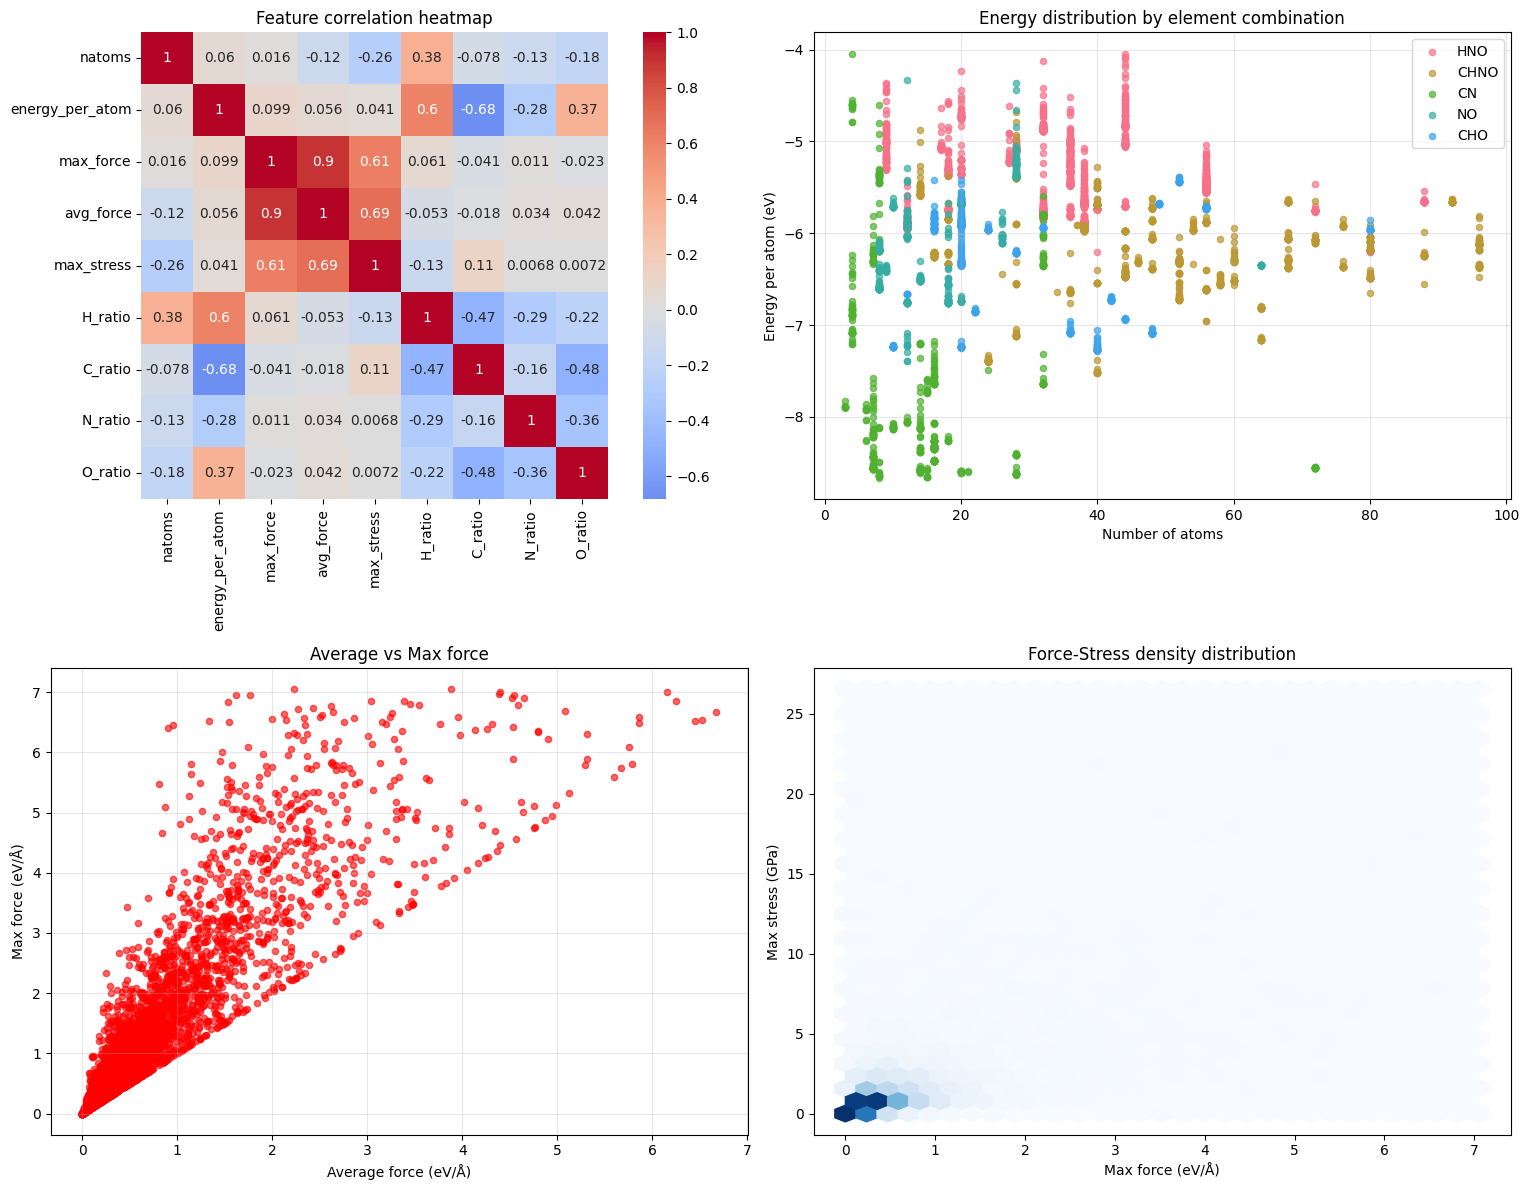


可视化完成！
生成的图片文件:
- chno_basic_distributions.png: 基本分布图
- chno_composition_analysis.png: 组成分析图
- chno_correlation_analysis.png: 相关性分析图

数据摘要:
- 筛选后保留 6696 个结构
- 涵盖 14 种元素组合
- 包含 230 种不同化学组成


In [8]:
import ase.io
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import warnings
warnings.filterwarnings('ignore')

def analyze_filtered_data(filename="chno_conservative.extxyz"):
    print(f"分析筛选数据: {filename}")
    print("="*60)
    
    try:
        atoms_list = ase.io.read(filename, ':')
    except:
        print(f"错误: 无法读取文件 {filename}")
        print("请确保文件存在且格式正确")
        return None
    
    print(f"筛选后结构数量: {len(atoms_list)}")
    
    data = []
    for i, atoms in enumerate(atoms_list):
        symbols = atoms.get_chemical_symbols()
        composition = Counter(symbols)
 
        natoms = len(atoms)
        energy = atoms.info.get('REF_energy', atoms.info.get('energy', 0))
        energy_per_atom = energy / natoms
        

        forces = atoms.arrays.get('REF_forces', atoms.arrays.get('forces', np.zeros((natoms, 3))))
        stress = atoms.info.get('REF_stress', atoms.info.get('stress', np.zeros(6)))
        
        max_force = np.linalg.norm(forces, axis=1).max() if len(forces) > 0 else 0
        avg_force = np.mean(np.linalg.norm(forces, axis=1)) if len(forces) > 0 else 0
        max_stress = np.abs(stress).max() if hasattr(stress, '__len__') and len(stress) > 0 else 0
        
        h_count = composition.get('H', 0)
        c_count = composition.get('C', 0)
        n_count = composition.get('N', 0)
        o_count = composition.get('O', 0)
        
        h_ratio = h_count / natoms
        c_ratio = c_count / natoms
        n_ratio = n_count / natoms
        o_ratio = o_count / natoms
        
        comp_str = ''.join([f"{elem}{count}" if count > 1 else elem 
                           for elem, count in sorted(composition.items())])
        
        present_elements = set([elem for elem, count in composition.items() if count > 0])
        element_combo = ''.join(sorted(present_elements))
        
        data.append({
            'index': i,
            'natoms': natoms,
            'composition': comp_str,
            'element_combo': element_combo,
            'energy': energy,
            'energy_per_atom': energy_per_atom,
            'max_force': max_force,
            'avg_force': avg_force,
            'max_stress': max_stress,
            'H_count': h_count,
            'C_count': c_count,
            'N_count': n_count,
            'O_count': o_count,
            'H_ratio': h_ratio,
            'C_ratio': c_ratio,
            'N_ratio': n_ratio,
            'O_ratio': o_ratio,
        })
    
    return pd.DataFrame(data), atoms_list

def create_comprehensive_plots(df, save_plots=True):
    print("\n正在创建可视化图表...")
    
    plt.style.use('default')
    sns.set_palette("husl")
    
    fig1, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    axes[0,0].hist(df['energy_per_atom'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0,0].set_xlabel('Energy per atom (eV)')
    axes[0,0].set_ylabel('Count')
    axes[0,0].set_title('Energy per atom distribution')
    axes[0,0].grid(True, alpha=0.3)

    axes[0,1].hist(df['max_force'], bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
    axes[0,1].set_xlabel('Max force (eV/Å)')
    axes[0,1].set_ylabel('Count')
    axes[0,1].set_title('Max force distribution')
    axes[0,1].grid(True, alpha=0.3)
    
    axes[0,2].hist(df['max_stress'], bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
    axes[0,2].set_xlabel('Max stress (GPa)')
    axes[0,2].set_ylabel('Count')
    axes[0,2].set_title('Max stress distribution')
    axes[0,2].grid(True, alpha=0.3)
    
    axes[1,0].hist(df['natoms'], bins=50, alpha=0.7, color='gold', edgecolor='black')
    axes[1,0].set_xlabel('Number of atoms')
    axes[1,0].set_ylabel('Count')
    axes[1,0].set_title('System size distribution')
    axes[1,0].grid(True, alpha=0.3)
    
    scatter = axes[1,1].scatter(df['natoms'], df['energy_per_atom'], 
                               c=df['max_force'], cmap='viridis', alpha=0.6, s=20)
    axes[1,1].set_xlabel('Number of atoms')
    axes[1,1].set_ylabel('Energy per atom (eV)')
    axes[1,1].set_title('Energy vs System size (color: max force)')
    axes[1,1].grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=axes[1,1], label='Max force (eV/Å)')
    
    axes[1,2].scatter(df['max_force'], df['max_stress'], alpha=0.6, s=20, color='purple')
    axes[1,2].set_xlabel('Max force (eV/Å)')
    axes[1,2].set_ylabel('Max stress (GPa)')
    axes[1,2].set_title('Force vs Stress correlation')
    axes[1,2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    if save_plots:
        plt.savefig('chno_basic_distributions.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    fig2, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    combo_counts = df['element_combo'].value_counts()
    axes[0,0].bar(combo_counts.index, combo_counts.values, color='lightblue', edgecolor='black')
    axes[0,0].set_xlabel('Element combination')
    axes[0,0].set_ylabel('Number of structures')
    axes[0,0].set_title('Element combination distribution')
    axes[0,0].tick_params(axis='x', rotation=45)
    axes[0,0].grid(True, alpha=0.3)

    element_ratios = df[['H_ratio', 'C_ratio', 'N_ratio', 'O_ratio']]
    axes[0,1].boxplot([element_ratios[col].dropna() for col in element_ratios.columns], 
                      labels=['H', 'C', 'N', 'O'])
    axes[0,1].set_ylabel('Element ratio')
    axes[0,1].set_title('Element ratio distribution')
    axes[0,1].grid(True, alpha=0.3)

    element_counts = df[['H_count', 'C_count', 'N_count', 'O_count']]
    element_counts.boxplot(ax=axes[1,0])
    axes[1,0].set_ylabel('Atom count')
    axes[1,0].set_title('Element atom count distribution')
    axes[1,0].tick_params(axis='x', rotation=45)
    axes[1,0].grid(True, alpha=0.3)

    df_nonzero = df[(df['C_count'] + df['N_count'] + df['O_count']) > 0].copy()
    if len(df_nonzero) > 0:
        total_cno = df_nonzero['C_count'] + df_nonzero['N_count'] + df_nonzero['O_count']
        c_norm = df_nonzero['C_count'] / total_cno
        n_norm = df_nonzero['N_count'] / total_cno
        o_norm = df_nonzero['O_count'] / total_cno
        
        scatter = axes[1,1].scatter(c_norm, n_norm, c=df_nonzero['H_ratio'], 
                                   cmap='plasma', alpha=0.6, s=30)
        axes[1,1].set_xlabel('C ratio (in C+N+O)')
        axes[1,1].set_ylabel('N ratio (in C+N+O)')
        axes[1,1].set_title('C-N-O composition (color: H ratio)')
        plt.colorbar(scatter, ax=axes[1,1], label='H ratio')
        axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    if save_plots:
        plt.savefig('chno_composition_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    fig3, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    corr_cols = ['natoms', 'energy_per_atom', 'max_force', 'avg_force', 'max_stress', 
                 'H_ratio', 'C_ratio', 'N_ratio', 'O_ratio']
    corr_matrix = df[corr_cols].corr()
    
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
                square=True, ax=axes[0,0])
    axes[0,0].set_title('Feature correlation heatmap')

    for combo in df['element_combo'].value_counts().head(5).index:
        subset = df[df['element_combo'] == combo]
        axes[0,1].scatter(subset['natoms'], subset['energy_per_atom'], 
                         label=combo, alpha=0.7, s=20)
    axes[0,1].set_xlabel('Number of atoms')
    axes[0,1].set_ylabel('Energy per atom (eV)')
    axes[0,1].set_title('Energy distribution by element combination')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
   
    axes[1,0].scatter(df['avg_force'], df['max_force'], alpha=0.6, s=20, color='red')
    axes[1,0].set_xlabel('Average force (eV/Å)')
    axes[1,0].set_ylabel('Max force (eV/Å)')
    axes[1,0].set_title('Average vs Max force')
    axes[1,0].grid(True, alpha=0.3)
    
    axes[1,1].hexbin(df['max_force'], df['max_stress'], gridsize=30, cmap='Blues')
    axes[1,1].set_xlabel('Max force (eV/Å)')
    axes[1,1].set_ylabel('Max stress (GPa)')
    axes[1,1].set_title('Force-Stress density distribution')
    
    plt.tight_layout()
    if save_plots:
        plt.savefig('chno_correlation_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

def print_detailed_statistics(df):
    print("\n详细统计信息:")
    print("="*60)
    
    print("1. 基本统计:")
    print(f"   总结构数: {len(df)}")
    print(f"   原子数范围: {df['natoms'].min()} - {df['natoms'].max()}")
    print(f"   平均原子数: {df['natoms'].mean():.1f}")
    print()
    
    print("2. 能量统计:")
    print(f"   能量范围: {df['energy'].min():.6f} - {df['energy'].max():.6f} eV")
    print(f"   单原子能量范围: {df['energy_per_atom'].min():.6f} - {df['energy_per_atom'].max():.6f} eV")
    print(f"   单原子能量平均: {df['energy_per_atom'].mean():.6f} eV")
    print()
    
    print("3. 力学性质统计:")
    print(f"   最大力范围: {df['max_force'].min():.6f} - {df['max_force'].max():.6f} eV/Å")
    print(f"   平均力范围: {df['avg_force'].min():.6f} - {df['avg_force'].max():.6f} eV/Å")
    print(f"   最大应力范围: {df['max_stress'].min():.6f} - {df['max_stress'].max():.6f} GPa")
    print()
    
    print("4. 元素组合统计:")
    combo_stats = df['element_combo'].value_counts()
    for combo, count in combo_stats.items():
        print(f"   {combo}: {count} 个结构 ({count/len(df)*100:.1f}%)")
    print()
    
    print("5. 主要化学组成 (前10个):")
    comp_stats = df['composition'].value_counts().head(10)
    for comp, count in comp_stats.items():
        print(f"   {comp}: {count} 个结构")
    print()
    
    print("6. 元素比例统计:")
    for elem in ['H', 'C', 'N', 'O']:
        ratio_col = f'{elem}_ratio'
        if ratio_col in df.columns:
            non_zero = df[df[ratio_col] > 0][ratio_col]
            if len(non_zero) > 0:
                print(f"   {elem}比例 (非零): 平均={non_zero.mean():.3f}, 中位数={non_zero.median():.3f}, 标准差={non_zero.std():.3f}")

def analyze_outliers(df):
    print("\n异常值分析:")
    print("="*60)
    
    outlier_cols = ['energy_per_atom', 'max_force', 'max_stress']
    outliers = {}
    
    for col in outlier_cols:
        mean_val = df[col].mean()
        std_val = df[col].std()
        lower_bound = mean_val - 3 * std_val
        upper_bound = mean_val + 3 * std_val
        
        outlier_mask = (df[col] < lower_bound) | (df[col] > upper_bound)
        outlier_indices = df[outlier_mask].index.tolist()
        outliers[col] = outlier_indices
        
        print(f"{col}异常值:")
        print(f"   正常范围: {lower_bound:.6f} - {upper_bound:.6f}")
        print(f"   异常值数量: {len(outlier_indices)} ({len(outlier_indices)/len(df)*100:.1f}%)")
        if len(outlier_indices) > 0:
            outlier_values = df.loc[outlier_indices, col]
            print(f"   异常值范围: {outlier_values.min():.6f} - {outlier_values.max():.6f}")
        print()
    
    return outliers

def main_visualization():
    print("CHNO Conservative数据可视化分析")
    print("="*60)

    result = analyze_filtered_data()
    if result is None:
        return
    
    df, atoms_list = result
    

    print_detailed_statistics(df)
    outliers = analyze_outliers(df)
    create_comprehensive_plots(df, save_plots=True)
    
    print("\n可视化完成！")
    print("生成的图片文件:")
    print("- chno_basic_distributions.png: 基本分布图")
    print("- chno_composition_analysis.png: 组成分析图") 
    print("- chno_correlation_analysis.png: 相关性分析图")
    
    print(f"\n数据摘要:")
    print(f"- 筛选后保留 {len(df)} 个结构")
    print(f"- 涵盖 {len(df['element_combo'].unique())} 种元素组合")
    print(f"- 包含 {len(df['composition'].unique())} 种不同化学组成")
    
    return df, atoms_list

if __name__ == "__main__":
    df, atoms_list = main_visualization()